# Example 1 &ndash; A single excitatory population

In this example, we reproduce figures 3 to 6 of the paper [*Beyond Wilson-Cowan dynamics: oscillations and chaos without inhibition*](https://doi.org/10.1007/s00422-022-00941-w). For details on PopNet's functions, see the [documentation](https://vincentpainchaud.github.io/PopNet/) of the package.

In [1]:
import popnet as pn
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from tqdm import tqdm
plt.ioff()

We start by defining the configuration with all parameters used in this example.

In [2]:
config = pn.default_config('1C', scale='micro')
config.resize_network(2000)

pop = config.network.populations[0]

pop.set_means(alpha=12.5, beta=3, gamma=1, theta=2)
pop.set_scales(theta=.4)
config.network.c = 8
config.network.reset_parameters()

config.initial_state = .1, .3
config.final_time = 20
config.delta = .01

## Solutions and phase plane

Here, we integrate numerically both the mean-field system and its subsystem that is equivalent to Wilson&ndash;Cowan's classical equation. First, we perform the integration with PopNet's methods.

In [3]:
solutions = []
for system_name in ['wilson-cowan', 'mean-field']:
    integrator = pn.get_integrator(config, system_name)
    integrator.run('ode')
    solutions.append(integrator.output())
    integrator.close()

Then, we define a Matplotlib figure on which we will plot the solutions and a phase plane.

In [4]:
mm = 1/25.4
preamble = ('\\usepackage[cal=cm]{mathalpha}'
            '\\usepackage{helvet}'
            '\\usepackage{sansmath}'
            '\\sansmath'
            '\\usepackage{bm}')

fig, axes = pn.figure(subplots=((2,3,(1,2)), (2,3,(4,5)), (2,3,(3,6))), figsize=(174*mm, 63*mm),
                      font_family='sans-serif', usetex=True, preamble=preamble, tight_layout=False)
fig.subplots_adjust(left=.035, right=.99, bottom=.13, top=.88, wspace=.25)

We plot the solutions on the left panels of the figure.

In [5]:
for j, solution in enumerate(solutions):
    solution.fig = fig
    solution.ax = axes[j]
    solution.plot_expectations(lw=1)
    solution.setup(units='$1/\\gamma$', set_xlabel=j==1, fontsize=8)
    solution.ax.tick_params(labelsize=8)
    if j == 0:
        solution.ax.set_xticklabels([])
        solution.legend(lw=1, ncol=3, fontsize=8, loc='lower right', bbox_to_anchor=(1.02, 1.02))

With PopNet's functions, we plot a phase plane of the mean-field system on the right panel, and we also plot the nullclines and the system's solution on the phase plane.

In [6]:
system = pn.get_system(config, 'mean-field')
plane = system.get_phase_plane((0,1))
plane.fig = fig
plane.ax = axes[-1]

plane.streamplot((100, 100), linewidth=.75, color='black', mask=True, arrowsize=.5, density=1.5)
plane.plot_nullclines(lw=1, mask=True)
plane.plot_solution(lw=1)
plane.setup(aspect='equal', fontsize=8)
plane.ax.spines['right'].set_visible(False)
plane.ax.spines['top'].set_visible(False)
plane.ax.plot([0,1], [1,0], color='black', lw=1)
plane.ax.yaxis.set_ticks_position('left')
plane.ax.xaxis.set_ticks_position('bottom')
plane.ax.tick_params(labelsize=8)
plane.legend(lw=1, fontsize=8, loc='upper right', bbox_to_anchor=(1, .8))

Finally, we draw the whole figure.

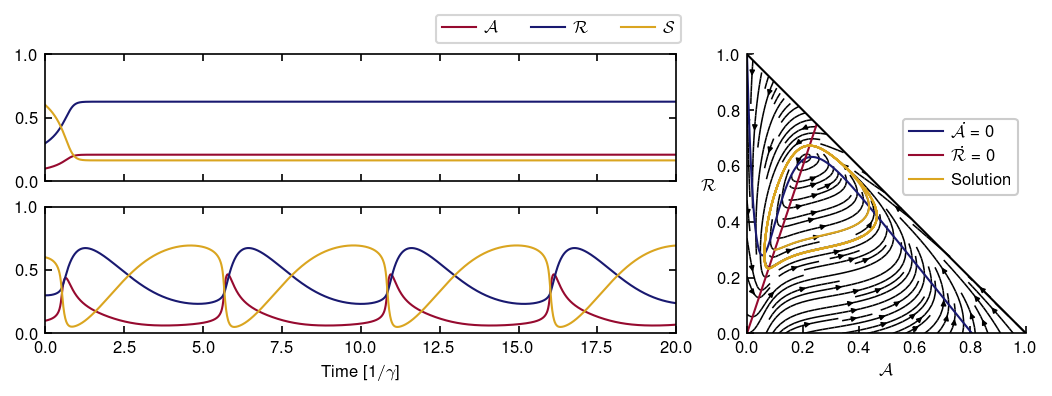

In [7]:
pn.draw()

## Eigenvalues of the Jacobian matrix

We now turn to the computation of the eigenvalues of the Jacobian matrix of the mixed system that describes the transition between the mean-field system and its Wilson&ndash;Cowan subsystem. We will need the position of the steady state to which the Wilson&ndash;Cowan subsystem converges. Thus, we start by defining a new configuration with this steady state as the initial state.

In [8]:
integrator = pn.get_integrator(config, 'mixed')
integrator.system.epsilon = .1
integrator.run('ode')
test_state = integrator.states[-1][:2]
steady_state = integrator.system.find_equilibrium_near(test_state)
integrator.close()

steady_state_config = config.copy('1CS')
steady_state_config.initial_state = steady_state
steady_state_config.final_time = 1000
steady_state_config.delta = .01

Now, we compute the eigenvalues of the Jacobian matrix for many different values of the parameter &epsilon; that describes the transition between the mean-field system and its Wilson&ndash;Cowan subsystem.

In [9]:
epsilon = np.linspace(0, 1, 10001)
eigenvals = np.zeros((len(epsilon), 2), dtype=complex)

system = pn.get_system(steady_state_config, 'wilson-cowan')
eigenval_WC = system.get_eigenvals_at(steady_state)
eigenvals[0,:1] = eigenval_WC
eigenvals[0,1:] = None

system = pn.get_system(steady_state_config, 'mixed')
for j, e in enumerate(epsilon[1:]):
    system.epsilon = e
    eigenvals[j] = system.get_eigenvals_at(steady_state)

We also find an approximation of the value of &epsilon; at which the bifurcation occurs, precise to 15 digits.

In [10]:
epsilon_bifurcation, _ = system.find_bifurcation_near(steady_state, 15)
print(epsilon_bifurcation)

0.5305257615697234


We plot side by side the real and imaginary parts of the eigenvalues computed above.

In [11]:
fig, axes = pn.figure(subplots=(121, 122), figsize=(84*mm, 48*mm), font_family='sans-serif',
                      usetex=True, preamble=preamble, tight_layout=False)
fig.subplots_adjust(wspace=.2, left=.08, right=.97, bottom=.15, top=.84)

axes[0].plot([0,1], [0,0], '--', color='black', lw=.5)
colors = ['C2', 'C0']
ls = ['-', ':']
for j, eig in enumerate(eigenvals.T):
    axes[0].plot(epsilon, np.real(eig), color=colors[j], ls=ls[j],
                 label=f'$\\mathrm{{Re}}\\lambda_{j+1}$', linewidth=1)
    axes[1].plot(epsilon, np.imag(eig), color=colors[j], ls=ls[j],
                 label=f'$\\mathrm{{Im}}\\lambda_{j+1}$', linewidth=1)
for j, ax in enumerate(axes):
    ax.legend(ncol=2, loc='lower right', bbox_to_anchor=(1.045, 1.01),
              fontsize=8, handletextpad=.5)
    ax.tick_params(labelsize=8)
    ax.set_xscale('log')
    ax.yaxis.set_tick_params(pad=2)
    ax.xaxis.set_tick_params(which='both', direction='in', pad=3)
    ax.set_xlim([.01,1])
    ax.set_xlabel('$\\bm{\\varepsilon}$', fontsize=8, labelpad=1)
axes[0].set_ylim([-25, 2])

(-25.0, 2.0)

We add inset axes on the left panel to zoom on the part of the curve where the real parts of the eigenvalues cross the horizontal axis. Then, we draw the figure.

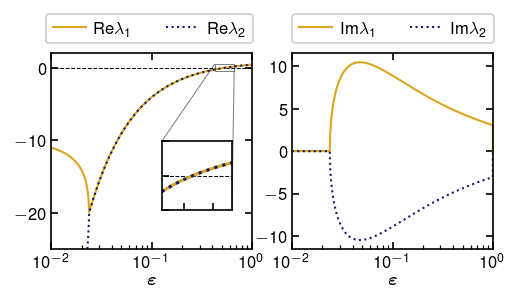

In [12]:
axins = axes[0].inset_axes([.55, .2, .35, .35])
axins.plot([0,1], [0,0], '--', color='black', lw=.5)
for j, eig in enumerate(eigenvals.T):
    axins.plot(epsilon, np.real(eig), color=colors[j], ls=ls[j])
axins.set_xlim([.8*epsilon_bifurcation, 1.25*epsilon_bifurcation])
axins.set_ylim([-.5, .5])
axins.set_xticklabels('')
axins.set_yticklabels('')
axins.tick_params(direction='in')
_, connector_lines = axes[0].indicate_inset_zoom(axins, edgecolor='black', lw=.5)
for line in connector_lines:
    line.set(linewidth=.5)

pn.draw()

## Bifurcation diagram

We now compute the three-dimensional bifurcation diagram associated with the Hopf bifurcation that occurs when the real parts of the eigenvalues plotted above change signs. To do so, we integrate the mixed system for 250 different values of &epsilon;, from an initial state very close to the steady state that becomes unstable as &epsilon; grows.

In [13]:
diagram_config = config.copy('1CD')
diagram_config.final_time = 20
diagram_config.delta = .01

integrator = pn.get_integrator(steady_state_config, 'mixed')
diagram_integrator = pn.get_integrator(diagram_config, 'mixed')

epsilon = np.linspace(0, 1, 251)[1:]
states = []

for e in tqdm(epsilon):
    steady_state_config.add_random_uniform_perturbation(.01)
    integrator.system.epsilon = e
    integrator.reset()
    integrator.run('ode')

    diagram_config.initial_state[:2] = integrator.states[-1]
    diagram_integrator.system.epsilon = e
    diagram_integrator.reset()
    diagram_integrator.run('ode')
    states.append(diagram_integrator.states)

100%|█████████████████████████████████████████████████████████████| 250/250 [08:58<00:00,  2.15s/it]


To draw the diagram, we plot all solutions together. We draw the figure twice, seen from two different angles.

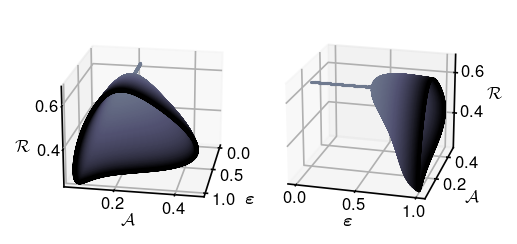

In [14]:
fig, ax = pn.figure(figsize=(84*mm, 36*mm), font_family='sans-serif', usetex=True, preamble=preamble, tight_layout=False)
fig.delaxes(ax)
fig.subplots_adjust(wspace=0, top=1.06, bottom=.06, left=.04, right=.96)

pos = {10: 121, -75: 122}
labelpads = { 10: {'x': -6,  'y': -11, 'z': -9},
             -75: {'x': -11, 'y': -8,  'z': -7}}
tickpads = { 10: {'x': -5, 'y': -6, 'z': -7},
            -75: {'x': -6, 'y': -5, 'z': -6}}
ha = { 10: {'x': 'left',   'y': 'center', 'z': 'right'},
      -75: {'x': 'center', 'y': 'left',   'z': 'left'}}
va = { 10: {'x': 'center', 'y': 'top',    'z': 'center'},
      -75: {'x': 'top',    'y': 'center', 'z': 'center'}}

for angle in [10, -75]:
    ax = fig.add_subplot(pos[angle], projection='3d')
    ax.view_init(elev=20, azim=angle)

    cmap = mpl.cm.get_cmap('bone')
    for j, e in enumerate(epsilon):
        X = e * np.ones(diagram_config.iterations+1)
        color = cmap(1/2 * (1 - e**5))
        if e < .5:
            ax.plot([e], [states[j][-1,0]], [states[j][-1,1]], '.', ms=1, color=color)
        elif angle == 10:
            ax.plot(X, states[j][:,0], states[j][:,1], color=color,  linewidth=1.9)
        else:
            ax.plot(X, states[j][:,0], states[j][:,1], color=color)

    ax.set_xlabel('$\\bm{\\varepsilon}$', fontsize=8, rotation=0, labelpad=labelpads[angle]['x'])
    ax.set_ylabel('$\\mathcal{A}$', fontsize=8, rotation=0, labelpad=labelpads[angle]['y'])
    ax.set_zlabel('$\\mathcal{R}$', fontsize=8, rotation=0, labelpad=labelpads[angle]['z'])

    for coord, axis in zip(['x', 'y', 'z'], [ax.xaxis, ax.yaxis, ax.zaxis]):
        axis.set_rotate_label(False)
        ax.tick_params(labelsize=8, axis=coord, pad=tickpads[angle][coord])
        for tick in axis.get_majorticklabels():
            tick.set_horizontalalignment(ha[angle][coord])
            tick.set_verticalalignment(va[angle][coord])
plt.show()

## Trajectory

Finally, we compare the behavior of the dynamical systems with the macroscopic behavior of a trajectory obtained from a stochastic simulation of the Markov chain that describes the microscopic behavior of the network's state. Note that since the trajectory is randomly generated, it is of course slightly different from the trajectory shown in the paper.

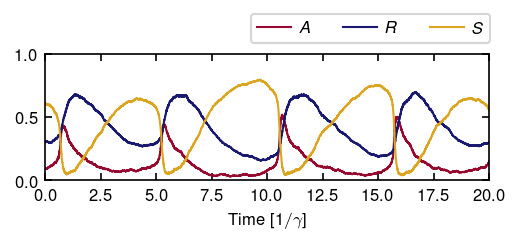

In [15]:
simulator = pn.get_simulator(config, act='sigmoid')
simulator.run()
trajectory = simulator.output()
simulator.close()

trajectory.activate(figsize=(84*mm, 37*mm), font_family='sans-serif', usetex=True, preamble=preamble, tight_layout=False)
trajectory.fig.subplots_adjust(left=.07, right=.965, bottom=.22, top=.8)

trajectory.plot_fractions(lw=1)
trajectory.setup(units='$1/\\gamma$', fontsize=8)
trajectory.ax.tick_params(labelsize=8)
trajectory.ax.set_xticks([2.5*n for n in range(9)])
trajectory.legend(lw=1, ncol=3, fontsize=8, loc='lower right', bbox_to_anchor=(1.02, 1.02))

pn.draw()